# Correlation Between SDO and GOES-14 Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.time
import astropy.units as u
from astropy.visualization import quantity_support, time_support
from sunpy.net import Fido
from sunpy.net import attrs as a
import sys
from scipy.signal import savgol_filter
from scipy import stats
import pandas as pd
import cdflib
import dateutil
import dask.dataframe as dd
from dask.distributed import Client
from scipy.signal import savgol_filter
from scipy import stats
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import netCDF4 #as nc
from scipy.io import netcdf
import glob
import xarray as xr
#from sscws.sscws import SscWs
import warnings
warnings.filterwarnings("ignore")
#%matplotlib widget
#from yellowbrick.regressor import CooksDistance

# Read and Treat Data

In [3]:
# SDO
df_sdo = dd.read_parquet("/efs/sdoradbelt/data/sdo_headers", columns=['NSPIKES','WAVELNTH','GAEZ_OBS','EXPTIME'])
df_sdo = df_sdo.set_index(df_sdo.index, sorted=True) # solve the sorting issue

In [34]:
year_start = 2018; year_end = 2018
month_start = 3; month_end = 3
day_start = 15; day_end = 25
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(1) #change to 15 minutes
exposure_in = df_sdo[df_sdo['WAVELNTH'] == 304]['EXPTIME'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [36]:
print(exposure_in[exposure_in>10])

T_OBS
2018-03-20 20:11:00+00:00    12.666667
2018-03-20 20:12:00+00:00    26.000000
2018-03-20 20:13:00+00:00    26.000000
2018-03-20 20:14:00+00:00    22.571429
2018-03-20 20:15:00+00:00    19.142857
2018-03-20 20:16:00+00:00    15.714286
2018-03-20 20:17:00+00:00    12.285714
Freq: T, Name: EXPTIME, dtype: float64


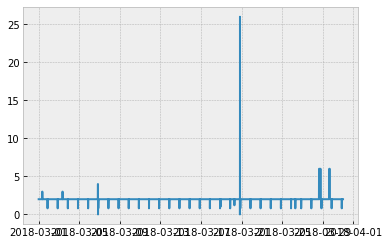

In [35]:
plt.plot(exposure_in)

# Orbits 3D Plot

In [ ]:
x = np.array([0.02, 0.028, 0.053, 0.078, 0.102])
print(np.mean(x))
print(np.std(x))

# Get Equator - Non Equator Correlations

In [ ]:
e_flux_kV = [40,75]#,150,275,475]
for telescope in range(1,10): 
    print('Telescope {}'.format(telescope))
    for flux in  e_flux_kV: # choose from 1 to 5
        wavelengths = [94,131,171,193,211,304,335]
        wl_p_cor_eq = []; wl_s_cor_eq = []; wl_p_cor_neq = []; wl_s_cor_neq = []; wl_p_cor_all = []; wl_s_cor_all = []
        for wl in wavelengths:
            print(wl)
            # GOES (Select Telescope, Electron Flux and Parameter)
            df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(telescope,flux))
            # Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
            year_start = 2018; year_end = 2019
            month_start = 1; month_end = 12
            day_start = 1; day_end = 30
            start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
            cadence = '{}min'.format(1) #change to 15 minutes
            z_sdo = df_sdo[df_sdo['WAVELNTH'] == wl]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
            nspikes = df_sdo[df_sdo['WAVELNTH'] == wl]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
            cor_flux = df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
            cor_flux[cor_flux<0] = 0
            # Pick Equator
            nspikes_eq = []; nspikes_non_eq = []
            e_flux_eq = []; e_flux_non_eq = []
            for i in range(0,len(z_sdo)):
                if z_sdo[i] >= -2*10**6 and z_sdo[i] <= 2*10**6:
                    nspikes_eq.append(nspikes[i])
                    e_flux_eq.append(cor_flux[i])
                else:
                    nspikes_non_eq.append(nspikes[i])
                    e_flux_non_eq.append(cor_flux[i])
            wl_p_cor_eq.append(stats.pearsonr(nspikes_eq,e_flux_eq)[0])
            wl_s_cor_eq.append(stats.spearmanr(nspikes_eq,e_flux_eq)[0])
            wl_p_cor_neq.append(stats.pearsonr(nspikes_non_eq,e_flux_non_eq)[0])
            wl_s_cor_neq.append(stats.spearmanr(nspikes_non_eq,e_flux_non_eq)[0])
            wl_p_cor_all.append(stats.pearsonr(nspikes,cor_flux)[0])
            wl_s_cor_all.append(stats.spearmanr(nspikes,cor_flux)[0])
            if float(stats.spearmanr(nspikes_eq,e_flux_eq)[0]) > float(0.75):
                print('Good Correlation ({}) at {}/{}'.format(float(stats.pearsonr(nspikes_eq,e_flux_eq)[0]),wl,flux))

        # Print Correlations
        print('FLUX',flux)
        print('Equator Pearson/Spearman Correlation')
        print('r = ',np.mean(wl_p_cor_eq),'+-',np.std(wl_p_cor_eq),' / rho = ',np.mean(wl_s_cor_eq),'+-',np.std(wl_s_cor_eq))
        print('Non-Equator Pearson/Spearman Correlation')
        print('r = ',np.mean(wl_p_cor_neq),'+-',np.std(wl_p_cor_neq),' / rho = ',np.mean(wl_s_cor_neq),'+-',np.std(wl_s_cor_neq))
        print('Combined Pearson/Spearman Correlation')
        print('r = ',np.mean(wl_p_cor_all),'+-',np.std(wl_p_cor_all),' / rho = ',np.mean(wl_s_cor_all),'+-',np.std(wl_s_cor_all))
        print()

# Heatmap

In [9]:
# GOES (Select Telescope, Electron Flux and Parameter)
df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(3,40))
# Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2018; year_end = 2019
month_start = 1; month_end = 12
day_start = 1; day_end = 30
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(10) #change to 15 minutes
z_sdo_in = df_sdo[df_sdo['WAVELNTH'] == 304]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_in = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
exposure_in = df_sdo[df_sdo['WAVELNTH'] == 304]['EXPTIME'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
#plt.plot(gg)
cor_flux_in = df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

ValueError: Can only resample dataframes with known divisions
See https://docs.dask.org/en/latest/dataframe-design.html#partitions
for more information.

In [ ]:
nspikes_exp = []; cor_flux_exp = []; exposure_exp = []; z_sdo_exp = []
for i in range(0,len(nspikes_in)):
    if exposure_in[i] > 0.5 and cor_flux_in[i] > 10:
        nspikes_exp.append(nspikes_in[i])
        cor_flux_exp.append(cor_flux_in[i])
        exposure_exp.append(exposure_in[i])
        z_sdo_exp.append(z_sdo_in[i])
nspikes = np.array(nspikes_exp)
cor_flux = np.array(cor_flux_exp)
exposure = np.array(exposure_exp)
z_sdo = np.array(z_sdo_exp)

IndexError: index 1049760 is out of bounds for axis 0 with size 1049760

In [ ]:
nspikes = nspikes/exposure

In [ ]:
# Getting rid of small values
idx = np.where(nspikes < 1500)[0] #& (nspikes > 0.5*1e5)
nspikes_small = np.array(nspikes)[idx]
cor_flux_small = np.array(cor_flux)[idx]
nspikes_clean = np.delete(np.array(nspikes),idx)
cor_flux_clean = np.delete(np.array(cor_flux),idx)
z_sdo_clean = np.delete(np.array(z_sdo),idx)
#idx = np.where(nspikes_clean > 3.5*1e5)[0]
#nspikes_large = np.array(nspikes_clean)[idx]
#cor_flux_large = np.array(cor_flux_clean)[idx]
#nspikes_clean = np.delete(np.array(nspikes_clean),idx)
#cor_flux_clean = np.delete(np.array(cor_flux_clean),idx)

nspikes = nspikes_clean
cor_flux = cor_flux_clean
z_sdo = z_sdo_clean

In [ ]:
# Pick Equator
nspikes_eq = []; cor_flux_eq = []; 
for i in range(0,len(nspikes)):
    if z_sdo[i] >= -2*10**6 and z_sdo[i] <= 2*10**6:
        nspikes_eq.append(nspikes[i])
        cor_flux_eq.append(cor_flux[i])

In [ ]:
nspikes_log = np.log10(nspikes)
cor_flux_log = np.log10(cor_flux)
nspikes_eq_log = np.log10(nspikes_eq)
cor_flux_eq_log = np.log10(cor_flux_eq)

In [15]:
# Getting rid of small values FOR EQUATOR
#idx_eq = np.where((nspikes < 3000) & (nspikes > 0.5*1e5))[0]
#nspikes_eq_small = np.array(nspikes_eq)[idx_eq]
#cor_flux_eq_small = np.array(cor_flux_eq)[idx]
#nspikes_eq = np.delete(np.array(nspikes_eq),idx_eq)
#cor_flux_eq = np.delete(np.array(cor_flux_eq),idx_eq)

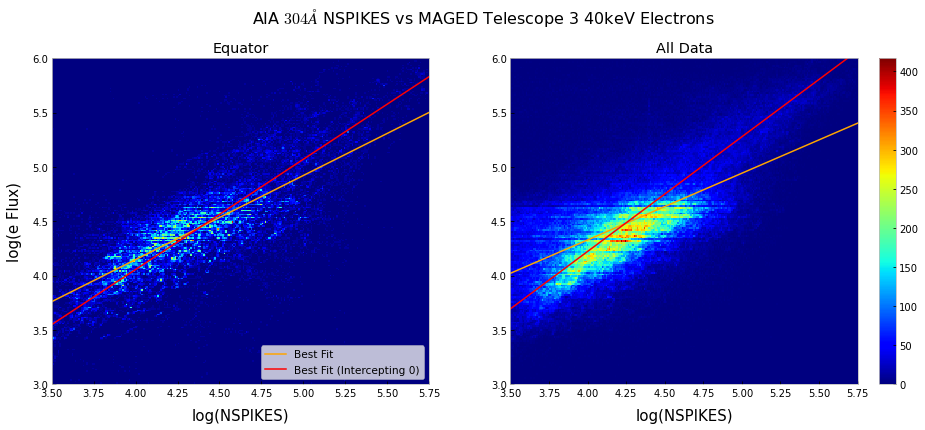

In [23]:
# Heatmap for best possible wavelength/keV/year
plt.style.use('bmh')
figure, axis = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 1.15]})
figure.suptitle(r'AIA $304\AA$ NSPIKES vs MAGED Telescope 3 40keV Electrons', fontsize=16,y=1)
#
im1 = axis[0].hist2d(nspikes_eq_log, cor_flux_eq_log, bins=300, cmap=plt.cm.jet)
axis[0].set_xlim(3.5,5.75)
axis[0].set_ylim(3,6)
axis[0].set_xlabel('log(NSPIKES)',size=15,labelpad=10)
axis[0].set_ylabel('log(e Flux)',size=15,labelpad=10)
axis[0].title.set_text('Equator')
m, b = np.polyfit(nspikes_eq_log, cor_flux_eq_log, 1)
x = np.linspace(2,13,50)
m2 = np.linalg.lstsq(np.array(nspikes_eq_log).reshape(-1,1), cor_flux_eq_log)[0][0]
axis[0].plot(x, m*x+b,linewidth=1.5,c='orange',label='Best Fit')
axis[0].plot(x, m2*x,linewidth=1.5,c='red',label='Best Fit (Intercepting 0)')
axis[0].legend(loc='lower right',fontsize=10.5)
#
im1 = axis[1].hist2d(nspikes_log, cor_flux_log, bins=300, cmap=plt.cm.jet)
axis[1].set_xlim(3.5,5.75)
axis[1].set_ylim(3,6)
axis[1].set_xlabel('log(NSPIKES)',size=15,labelpad=10)
axis[1].title.set_text('All Data')
m, b = np.polyfit(nspikes_log, cor_flux_log, 1)
x = np.linspace(2,13,50)
m2 = np.linalg.lstsq(np.array(nspikes_log).reshape(-1,1), cor_flux_log)[0][0]
axis[1].plot(x, m*x+b,linewidth=1.5,c='orange')
axis[1].plot(x, m2*x,linewidth=1.5,c='red')
figure.colorbar(im1[3])

#plt.savefig('Heatmaps.png')
plt.show()

In [25]:
stats.pearsonr(nspikes_eq,cor_flux_eq)[0]

0.7835039908861148

In [27]:
stats.spearmanr(nspikes_eq,cor_flux_eq)[0]

0.7643285386369539

In [26]:
stats.pearsonr(nspikes,cor_flux)[0]

0.6770957573605035

In [28]:
stats.spearmanr(nspikes,cor_flux)[0]

0.6255760184761461

In [ ]:
plt.style.use('bmh')
figure, axis = plt.subplots(1, 2, figsize=(14,5))
figure.suptitle('Spread of NSPIKES (100 Bins)', fontsize=16,y=0.95)

axis[0].hist(nspikes,bins=100)
axis[0].set_xlabel('NSPIKES',size=15,labelpad=10)
axis[0].set_ylabel('Number of Points',size=15,labelpad=10)
axis[0].set_facecolor('white')
#
axis[1].hist(nspikes_log,bins=100)
axis[1].set_xlabel('log(NSPIKES)',size=15,labelpad=10)
axis[1].set_facecolor('white')
#axis[1].set_ylabel('Number of Points',size=15,labelpad=10)

plt.savefig('NSPIKES_Histogram.png')
plt.show()

In [ ]:
# what are these low values? are they real or not? exclude them and check what they are. get some more depth in it. 

# Log for high energies

In [ ]:
# Try doing log of both for low energies

# Try Epead

# Equator Data Picking Plot

In [ ]:
   
# Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2018; year_end = 2018
month_start = 8; month_end = 8
day_start = 22; day_end = 22
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(1) #change to 15 minutes
z_sdo = df_sdo[df_sdo['WAVELNTH'] == 94]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 94]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_131 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_171 = df_sdo[df_sdo['WAVELNTH'] == 171]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_193 = df_sdo[df_sdo['WAVELNTH'] == 193]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_211 = df_sdo[df_sdo['WAVELNTH'] == 211]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_304 = df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_335 = df_sdo[df_sdo['WAVELNTH'] == 335]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

cor_flux = []
for flux in [40,75,150,275,475]:
    # GOES (Select Telescope, Electron Flux and Parameter)
    df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(2,flux))  
    cor_flux.append(df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate())


In [ ]:
# Graphing
fig, axs = plt.subplots(3,1,figsize=(30,10),gridspec_kw={'height_ratios': [1,1,1.5]})
fig.suptitle('Equator Data Selection',fontsize=27,y=0.935) #(October 15, 2019)

axs[0].plot(np.log10(cor_flux[0]),label='40'); axs[0].plot(np.log10(cor_flux[1]),label='75'); 
axs[0].plot(np.log10(cor_flux[2]),label='150'); axs[0].plot(np.log10(cor_flux[3]),label='275'); axs[0].plot(np.log10(cor_flux[4]),label='475')
axs[0].set_xticklabels([])
axs[0].set_ylabel('log(e Flux)',fontsize=20)
axs[0].legend(loc="upper right",title='Energy (keV)',prop={'size': 14})
# units: e/(cm^2 s sr keV)

axs[1].plot(np.log10(nspikes_94),label='94'); axs[1].plot(np.log10(nspikes_131),label='131'); axs[1].plot(np.log10(nspikes_171),label='171')
axs[1].plot(np.log10(nspikes_193),label='193'); axs[1].plot(np.log10(nspikes_211),label='211'); axs[1].plot(np.log10(nspikes_304),label='304'); axs[1].plot(np.log10(nspikes_335),label='335')
axs[1].set_xticklabels([])
#axs[0].set_ylim((0,1*10**6))
axs[1].set_ylabel('log(NSPIKES)',fontsize=20)
#axs[1].set_ylim(6.5,11)
axs[1].legend(loc="upper right",title=r'Wavelength ($\AA$)',prop={'size': 10})


axs[2].plot(z_sdo)
axs[2].axhline(y=-2*10**6,c='red',linewidth=0.5)
axs[2].axhline(y=2*10**6,c='red',linewidth=0.5)
axs[2].set_ylabel('SDO Latitude',fontsize=20)
axs[2].set_xlabel('Time',fontsize=20, labelpad=12)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('Equator_Selection.png')
plt.show()

# High Energy Logarithm

In [ ]:
# Get headers in all wavelengths along with GOES-14 data. Convert to int32 for less memory. Select time span, cadence and interpolate in case of NaNs.
year_start = 2018; year_end = 2019
month_start = 1; month_end = 12
day_start = 1; day_end = 30
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(1) #change to 15 minutes
#[94,131,171,193,211,304,335]
z_sdo = df_sdo[df_sdo['WAVELNTH'] == 131]['GAEZ_OBS'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
nspikes_94 = df_sdo[df_sdo['WAVELNTH'] == 131]['NSPIKES'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
#[40,75,150,275,475]
df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(2,475))  
cor_flux=df_goes['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()
df_goes2 = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(2,40))  
cor_flux2=df_goes2['cor_flux'].astype(np.int32).loc[start_d:end_d].resample(cadence).mean().compute().interpolate()

In [ ]:
cor_flux[cor_flux<=0] = 1
cor_flux.plot()
plt.figure()
cor_flux_log = np.log(cor_flux)
cor_flux_log.plot()
print(stats.pearsonr(nspikes_94,cor_flux)[0])
print(stats.pearsonr(nspikes_94,cor_flux_log)[0])

# Rest Stuff - Notes

In [ ]:
print('Correlation Value for Corrected vs. Uncorrected')
print('r = ',stats.pearsonr(cor_flux,uncor_flux)[0])

In [ ]:
e_eq = []; nspikes_94_eq = []; lat_eq = []; 
for i in range(0,len(lat)):
    if lat[i] >= -2*10**6 and lat[i] <= 2*10**6:
        nspikes_94_eq.append(nspikes_94[i])
        e_eq.append(cor_flux[i])
        lat_eq.append(lat[i])

In [ ]:
norm_lat_eq = (lat_eq-np.min(lat_eq))/(np.max(lat_eq) - np.min(lat_eq))

In [ ]:
print('Number of total points: ',np.shape(cor_flux),np.shape(nspikes_94))
print('Number of points on equator: ',np.shape(e_eq),np.shape(nspikes_94_eq))

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(e_eq)
plt.plot(norm_lat_eq*np.min(e_eq))

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(nspikes_94_eq)
plt.plot(norm_lat_eq*np.min(nspikes_94_eq))

In [ ]:
print('Correlation Value for Spikes v Flux on Equator')
print('r = ',stats.pearsonr(nspikes_94_eq,e_eq)[0])